<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-15.1" data-toc-modified-id="Figure-15.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 15.1</a></span></li><li><span><a href="#Figure-15.2" data-toc-modified-id="Figure-15.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 15.2</a></span></li><li><span><a href="#Figure-15.3" data-toc-modified-id="Figure-15.3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 15.3</a></span></li><li><span><a href="#Figure-15.6" data-toc-modified-id="Figure-15.6-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 15.6</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 15
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import signal as sig

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 15.1

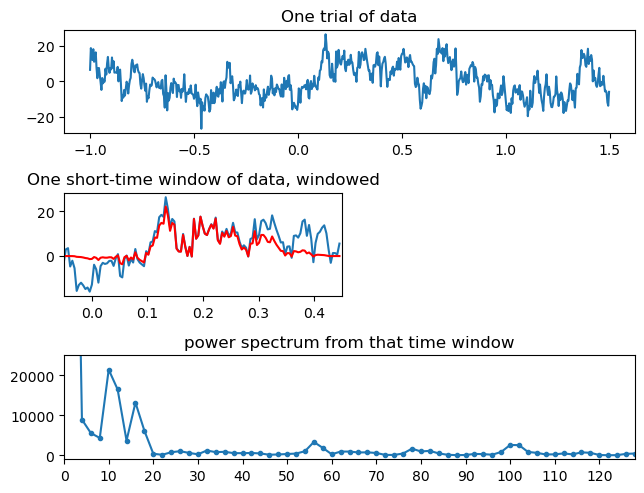

In [4]:
timewin = 500 # in ms

# convert s to idx
timewinidx = int(np.round(timewin/1000*(srate)));

# create hann taper function
hann_win = .5*(1-np.cos(2*np.pi*np.arange(timewinidx)/(timewinidx-1)));

# detrend data (useful to attentuate super-low frequency artifacts in FFT
# from sampled data)
d = sig.detrend(data[15,19,:]);

plt.subplot(3,1,1)
plt.plot(times,d)
plt.title('One trial of data')

stime = np.argmin(np.abs(times-(-.05)))

plt.subplot(3,2,3)
plt.plot(times[stime:stime+timewinidx],d[stime:stime+timewinidx])

plt.plot(times[stime:stime+timewinidx],d[stime:stime+timewinidx]*hann_win,'r')
plt.setp(plt.gca(),'xlim',[-.05, -.05+timewin/1000])
plt.title('One short-time window of data, windowed')
plt.tight_layout()

dfft = np.fft.fft(d[stime:stime+timewinidx]*hann_win)
f    = np.linspace(0,srate/2,len(hann_win)//2+1) # frequencies of FFT


plt.subplot(3,1,3)
plt.plot(f[1:],np.abs(dfft[1:int(np.floor(len(hann_win)/2.))+1])**2,'.-');
plt.title('power spectrum from that time window')
_=plt.setp(plt.gca(),'xlim',[1 ,128],'ylim',[-1000, 25000],'xticks',np.arange(0,srate/2.,10))

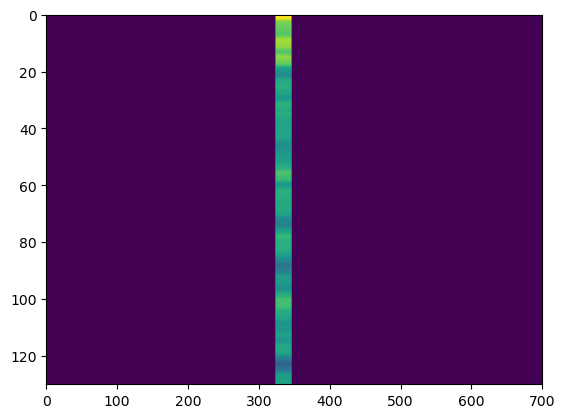

In [5]:
# create TF matrix and input column of data at selected time point
tf = np.zeros([len(hann_win)//2,pnts])
tf[:,stime+timewinidx//2-11:stime+timewinidx//2+10] = np.tile(np.abs(dfft[1:len(hann_win)//2+1])*2, [21,1]).T

plt.imshow(np.log10(tf+1), aspect='auto', extent=[0,700,130,0])

## Figure 15.2

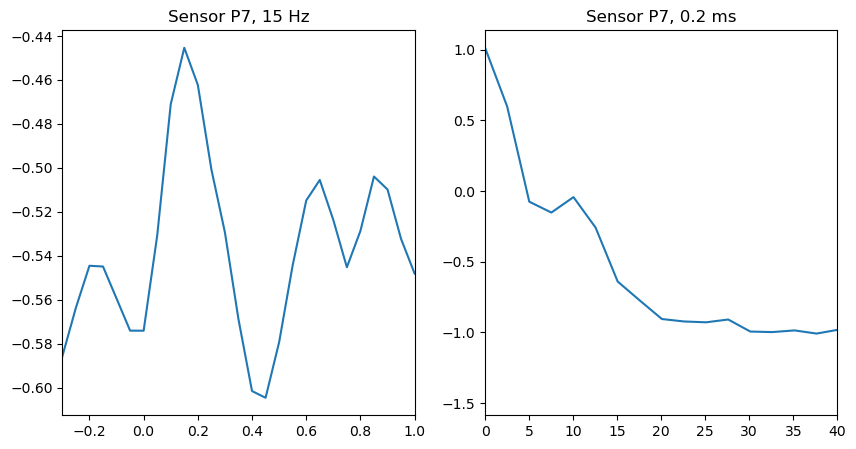

In [6]:
timewin        = 400 # in ms, for stFFT
times2save     = np.arange(-.3,1 + .05,.05) # in ms
channel2plot   = 'P7'
frequency2plot = 15 # in Hz
timepoint2plot = .2 # ms

# convert from ms to index
times2saveidx = np.zeros(times2save.shape);
for i in range(len(times2save)):
    times2saveidx[i]=np.argmin(np.abs(times-times2save[i]))

timewinidx = int(timewin/(1000/srate));
chan2useidx = chan_labels.index(channel2plot)



#create hann taper
hann_win = .5*(1-np.cos(2*np.pi*(np.arange(timewinidx))/(timewinidx-1)))
hann_win = np.reshape(hann_win,[len(hann_win),1])
#define frequencies
frex = np.linspace(0, srate/2, timewinidx//2+1);

#initialize power output matrix
tf = np.zeros([len(frex),len(times2save)])

#loop over time points and perform FFT
for timepointi in range(len(times2save)):
    
    #extract time series data for this center time point
    # note: the 'mod' function here corrects for even or odd number of points
        
    tempdat = data[:,chan2useidx,int(times2saveidx[timepointi]-np.floor(timewinidx/2)-1):int(times2saveidx[timepointi]+np.floor(timewinidx/2)-((timewinidx+1)%2))].T
        
    #multiply the two arrays together by broadcasting
    taperdat = tempdat * hann_win
    
    fdat = np.fft.fft(taperdat,axis=0)/timewinidx #
    tf[:,timepointi] = np.mean(np.abs(fdat[:int(np.floor(timewinidx/2)+1),:])**2,axis=1) 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
freq2plotidx = np.argmin(np.abs(frex-frequency2plot));
plt.plot(times2save,np.mean(np.log10(tf[freq2plotidx-3:freq2plotidx+3,:]),axis=0))
plt.title( 'Sensor ' + channel2plot + ', ' + str(frequency2plot) +' Hz' )
plt.setp(plt.gca(),'xlim',[times2save[0] ,times2save[-1]])

plt.subplot(1,2,2)
time2plotidx=np.argmin(np.abs(times2save-timepoint2plot));
plt.plot(frex,np.log10(tf[:,time2plotidx]))
plt.title( 'Sensor ' + channel2plot + ', ' + str(timepoint2plot) +' ms' )
_=plt.setp(plt.gca(),'xlim',[frex[0], 40])

Overlap of 99.9875%


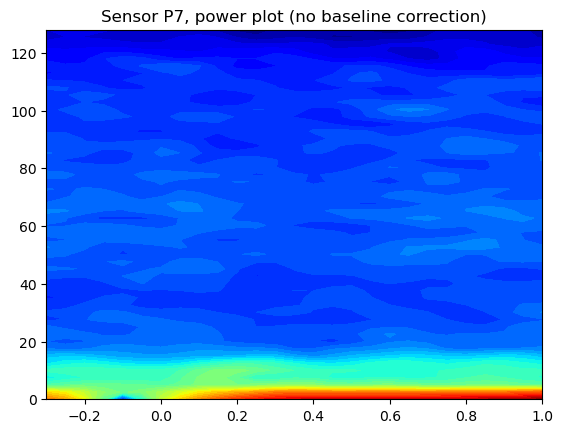

In [7]:
plt.contourf(times2save,frex,np.log10(tf),40,cmap="jet")
plt.title('Sensor ' + channel2plot + ', power plot (no baseline correction)')

print('Overlap of '  + str(100*(1-np.mean(np.diff(times2save))/timewin)) + '%')

## Figure 15.3

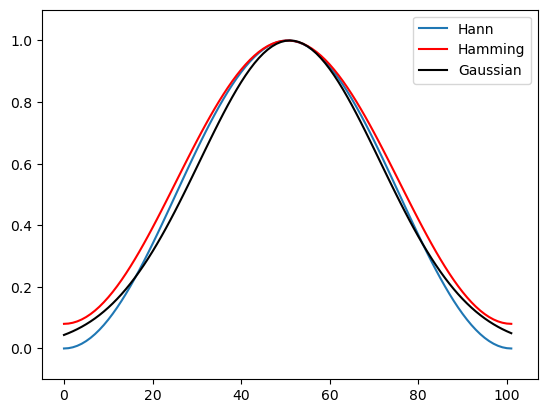

In [8]:
# create hamming
hamming_win = .54 - .46*np.cos(2*np.pi*(np.arange(timewinidx))/(timewinidx-1))

hann_win    = .5*(1-np.cos(2*np.pi*(np.arange(timewinidx))/(timewinidx-1)))

# create gaussian
gaus_win = np.exp(-.5*(2.5*(np.arange(-timewinidx/2,timewinidx/2))/(timewinidx/2))**2)

# plot together
plt.plot(hann_win)
plt.plot(hamming_win,'r')
plt.plot(gaus_win,'k')
plt.legend(['Hann','Hamming','Gaussian'])

_=plt.setp(plt.gca(),'xlim',[-5, timewinidx+5],'ylim',[-.1, 1.1],'yticks',np.arange(0,1.2,.2))

## Figure 15.6

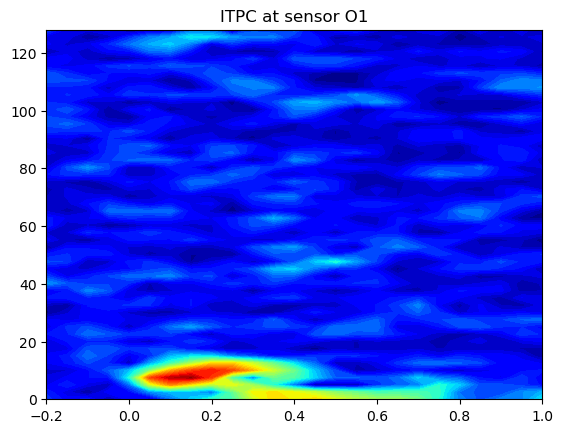

In [9]:
chan2use = 'O1';
chan2useidx = chan_labels.index(chan2use)
frequency2plot = 10 # in Hz

freq2plotidx = np.argmin(np.abs(frex-frequency2plot))

# initialize ITPC output matrix
itpc = np.zeros([len(frex),len(times2save)])

# loop over time points and perform FFT
for timepointi in range(len(times2save)):
    
    # extract time series data for this center time point
    # (yes, yes, it's a long line of code. Perhaps you can understand it
    # better by breaking it up into several lines to separately identify
    # channel index and time window?)
    tempdat = data[:, chan2useidx, int(times2saveidx[timepointi]-np.floor(timewinidx/2)-1):int(times2saveidx[timepointi]+np.floor(timewinidx/2)-((timewinidx+1)%2))].T
        
    taperdat =  hann_win[:, np.newaxis] * tempdat
    
    fdat = np.fft.fft(taperdat,axis=0)/timewinidx;
    itpc[:,timepointi] = np.abs(np.mean(np.exp(1j*np.angle(fdat[:int(np.floor(timewinidx/2)+1),:])),axis=1)) # average over trials

plt.xlim(-.2, 1)
plt.contourf(times2save,frex,itpc,40,cmap='jet')
_=plt.title('ITPC at sensor ' + chan2use)

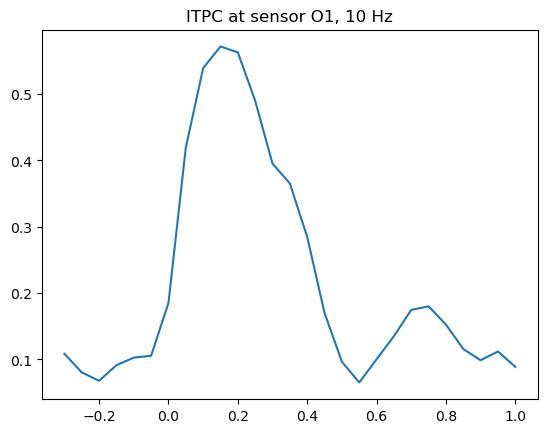

In [10]:
plt.plot(times2save,np.mean(itpc[freq2plotidx-2:freq2plotidx+2,:],axis=0))
_=plt.title('ITPC at sensor ' + chan2use +', ' +str(frequency2plot) + ' Hz')